<a href="https://colab.research.google.com/github/tdiego74/Clase_Data_Science_III_PBLC/blob/main/Proyecto_DS_III_Entrega_Final_Tocci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analisis de Reseñas de peliculas en español de FilmAffinity**

##**Abstracto con Motivación y Audiencia**

En este proyecto se analiza un conjunto de datos de reseñas obtenidas de FilmAffinity. Este trabajo está orientado a explorar patrones en el texto, realizar análisis de sentimientos y aplicar técnicas de procesamiento de lenguaje natural (NLP) para identificar insights significativos.

El objetivo principal es demostrar el flujo completo de análisis: desde la carga y limpieza del texto hasta el desarrollo de visualizaciones y modelos predictivos que puedan clasificar las reseñas según su polaridad o calificación.


##**Contexto Comercial y Analítico**

FilmAffinity es una plataforma de recomendaciones y críticas de películas que permite a los usuarios valorar y escribir reseñas sobre títulos cinematográficos. Las reseñas de los usuarios son una fuente valiosa de información para comprender las preferencias y emociones asociadas con el consumo de contenido audiovisual.

Este análisis busca responder preguntas como: ¿Qué palabras o frases son más comunes en las reseñas positivas y negativas? ¿Cómo varían las emociones según el género cinematográfico? Este conocimiento podría ser utilizado por la industria del entretenimiento para adaptar contenido a las expectativas de los usuarios.


##**Preguntas/Hipótesis a Resolver**

1. ¿Qué palabras o frases predominan en las reseñas positivas y negativas?
2. ¿Es posible clasificar automáticamente las reseñas según su calificación o polaridad?
3. ¿Qué características textuales pueden estar asociadas con ciertas puntuaciones o géneros?


##**Objetivo**

El objetivo de este proyecto es analizar y procesar el texto de las reseñas de FilmAffinity mediante técnicas de NLP. Esto incluye:
- Preprocesamiento y limpieza del texto.
- Análisis exploratorio para identificar patrones significativos.
- Entrenamiento de un modelo para predecir la polaridad o calificación de las reseñas.



In [1]:
# Instalaciones necesarias (se ejecutan solo si no están instaladas)
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install wordcloud
!pip install matplotlib

# Importaciones generales
import pandas as pd  # Manejo de datos
import numpy as np  # Cálculos adicionales
import matplotlib.pyplot as plt  # Gráficos
import re  # Expresiones regulares
from collections import Counter  # Contar elementos
import spacy  # Procesamiento de lenguaje natural
from wordcloud import WordCloud  # Nube de palabras
from sklearn.feature_extraction.text import CountVectorizer  # N-gramas

# Cargar el modelo en español para spaCy
nlp = spacy.load('es_core_news_sm')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 90.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 6.9 MB/s eta 0:00:00


In [2]:
# import pandas as pd

# Leer el archivo desde GitHub usando un enfoque más robusto
df = pd.read_csv(
    'https://github.com/tdiego74/Clase_Data_Science_III_PBLC/raw/main/reviews_filmaffinity.csv',
    sep=r'\|\|',  # Expresión regular para delimitador ||
    engine='python',
    quoting=3  # Ignorar comillas
)

# Mostrar las primeras filas
print("Primeras filas del dataset:")
print(df.head())

# Mostrar información del DataFrame
print("\nInformación general del dataset:")
print(df.info())





Primeras filas del dataset:
               film_name   gender film_avg_rate  review_rate  \
0  Ocho apellidos vascos  Comedia           6,0          3.0   
1  Ocho apellidos vascos  Comedia           6,0          2.0   
2  Ocho apellidos vascos  Comedia           6,0          2.0   
3  Ocho apellidos vascos  Comedia           6,0          2.0   
4  Ocho apellidos vascos  Comedia           6,0          2.0   

                                        review_title  \
0     OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO   
1                                     El perro verde   
2  Si no eres de comer mierda... no te comas esta...   
3                                    Aida: The movie   
4               UN HOMBRE SOLO (Julio Iglesias 1987)   

                                         review_text  
0  La mayor virtud de esta película es su existen...  
1  No soy un experto cinéfilo, pero pocas veces m...  
2  Si no eres un incondicional del humor estilo T...  
3  No sé qué está pasando, si 

In [3]:
# Distribución de géneros
print("Distribución de géneros:")
print(df['gender'].value_counts())

# Distribución de calificaciones individuales (review_rate)
print("\nDistribución de calificaciones (review_rate):")
print(df['review_rate'].value_counts())

# Distribución de calificaciones promedio de películas (film_avg_rate)
print("\nEstadísticas descriptivas de calificaciones promedio (film_avg_rate):")
print(df['film_avg_rate'].describe())


Distribución de géneros:
gender
Comedia       2495
Drama         1671
Terror         941
Aventuras      939
Thriller       762
Fantástico     495
Cine negro     419
Romance        284
Animación      284
Intriga        248
Musical         65
Name: count, dtype: int64

Distribución de calificaciones (review_rate):
review_rate
8.0     1292
7.0     1282
6.0     1256
5.0      978
9.0      833
3.0      695
1.0      639
4.0      590
2.0      523
10.0     513
Name: count, dtype: int64

Estadísticas descriptivas de calificaciones promedio (film_avg_rate):
count     8603
unique      28
top        7,2
freq      1129
Name: film_avg_rate, dtype: object


Estadísticas descriptivas de la longitud de las oraciones:
count    8603.000000
mean      213.725793
std       154.962512
min         5.000000
25%       100.000000
50%       170.000000
75%       288.000000
max      1063.000000
Name: sentence_length, dtype: float64


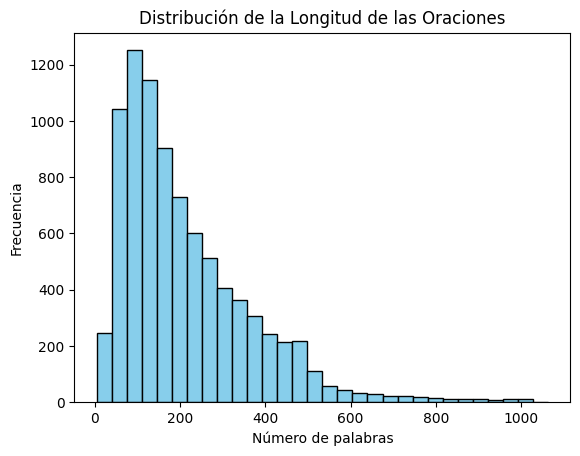

In [4]:
# Longitud de las oraciones
df['sentence_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print("Estadísticas descriptivas de la longitud de las oraciones:")
print(df['sentence_length'].describe())

# Histograma de la longitud de las oraciones
# import matplotlib.pyplot as plt

plt.hist(df['sentence_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de las Oraciones')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()


El corpus tiene una buena variabilidad en la longitud de las reseñas.
Las reseñas más largas podrían contener mayor riqueza semántica, mientras que las más cortas podrían ser directas y concisas.

Palabras más comunes:
de: 95587
que: 76809
la: 59955
y: 51432
en: 39433
el: 35813
a: 34636
es: 24943
un: 24872
no: 23675


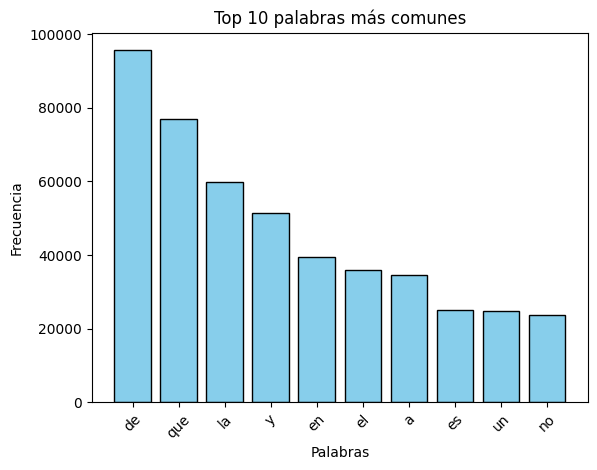

In [6]:
# Importaciones necesarias
#from collections import Counter

# Combinar todas las reseñas en un único string
all_words = ' '.join(df['review_text'].dropna())

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words.split())

# Mostrar las 10 palabras más comunes
print("Palabras más comunes:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

# Visualización de las palabras más comunes
import matplotlib.pyplot as plt

# Preparar datos para el gráfico
words, counts = zip(*word_counts.most_common(10))

# Crear el gráfico de barras
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.title('Top 10 palabras más comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


Este análisis confirma la necesidad de limpiar el texto, eliminando stopwords para resaltar palabras más relevantes.

In [24]:
# Importar librerías necesarias
# import re
# import spacy

# Cargar modelo en español para obtener las stopwords
nlp = spacy.load('es_core_news_sm')
stopwords = nlp.Defaults.stop_words

# Función para limpiar el texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar puntuación y caracteres especiales
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)
    # Eliminar stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords]
    # Reconstruir el texto limpio
    return ' '.join(words)

# Aplicar la limpieza al texto de las reseñas
df['cleaned_review_text'] = df['review_text'].apply(lambda x: clean_text(str(x)))

# Mostrar ejemplo de reseña antes y después de limpiar
print("Ejemplo de texto antes y después de la limpieza:")
print("")
print("Original:", df['review_text'].iloc[0])
print("")
print("Limpio:", df['cleaned_review_text'].iloc[0])


Ejemplo de texto antes y después de la limpieza:

Original: La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines

Palabras más comunes:
película: 16398
cine: 6157
historia: 4832
personajes: 2834
películas: 2722
español: 2523
guión: 2418
actores: 2343
personaje: 2076
director: 2016


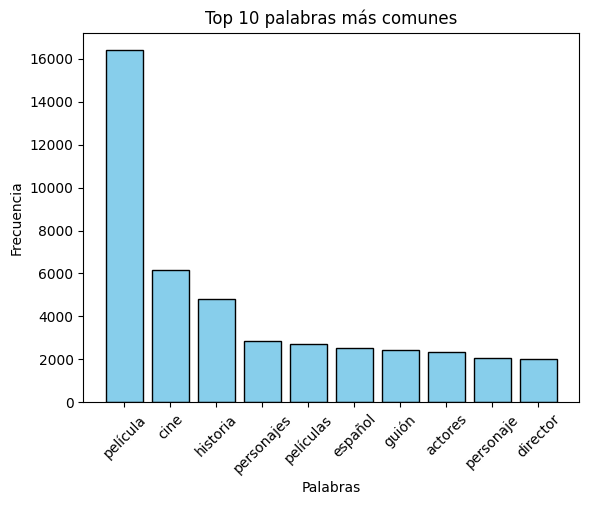

In [12]:
# Importaciones necesarias
#from collections import Counter

# Combinar todas las reseñas en un único string
all_words = ' '.join(df['cleaned_review_text'].dropna())

# Contar la frecuencia de cada palabra
word_counts = Counter(all_words.split())

# Mostrar las 10 palabras más comunes
print("Palabras más comunes:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

# Visualización de las palabras más comunes
import matplotlib.pyplot as plt

# Preparar datos para el gráfico
words, counts = zip(*word_counts.most_common(10))

# Crear el gráfico de barras
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.title('Top 10 palabras más comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

En el grafico anterior se puede observar el resultado de las palabras mas comunes luego de la limpieza de texto y eliminacion de las stopwords

Etiquetas POS más comunes:
NOUN: 245715
ADJ: 233075
VERB: 148872
PROPN: 63721
ADV: 19753
AUX: 7667
DET: 3414
ADP: 2646
NUM: 2335
PRON: 1765
SCONJ: 554
CCONJ: 419
INTJ: 149
PUNCT: 104
SYM: 58
X: 10
PART: 3


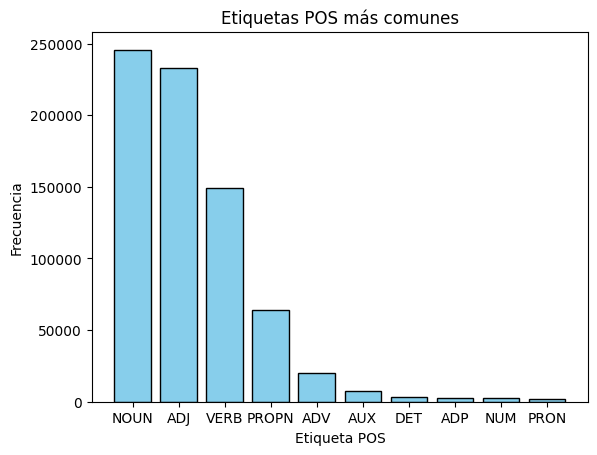

In [8]:
# Importar spaCy (asegúrate de que ya está cargado)
#import spacy
#from collections import Counter

# Cargar el modelo en español
nlp = spacy.load('es_core_news_sm')

# Función para analizar las partes del discurso (POS)
def get_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Aplicar el análisis POS a una muestra del texto limpio
df['pos_tags'] = df['cleaned_review_text'].apply(lambda x: get_pos_tags(x))

# Contar las etiquetas POS en todo el corpus
all_pos_tags = [tag for tags in df['pos_tags'] for tag in tags]
pos_counts = Counter(all_pos_tags)

# Mostrar las etiquetas POS más comunes
print("Etiquetas POS más comunes:")
for tag, count in pos_counts.most_common():
    print(f"{tag}: {count}")

# Visualización de las etiquetas POS
import matplotlib.pyplot as plt

# Preparar datos para el gráfico
tags, counts = zip(*pos_counts.most_common(10))

# Crear gráfico de barras
plt.bar(tags, counts, color='skyblue', edgecolor='black')
plt.title('Etiquetas POS más comunes')
plt.xlabel('Etiqueta POS')
plt.ylabel('Frecuencia')
plt.show()



Este análisis confirma que el corpus está bien balanceado para tareas relacionadas con descripción y evaluación (sustantivos y adjetivos predominantes).
Los adjetivos serán clave para entender el tono y la polaridad en las reseñas.

Estadísticas descriptivas de la longitud de las palabras:
count    8603.000000
mean        7.369988
std         0.505959
min         5.000000
25%         7.063158
50%         7.365079
75%         7.669688
max        17.666667
Name: word_length, dtype: float64


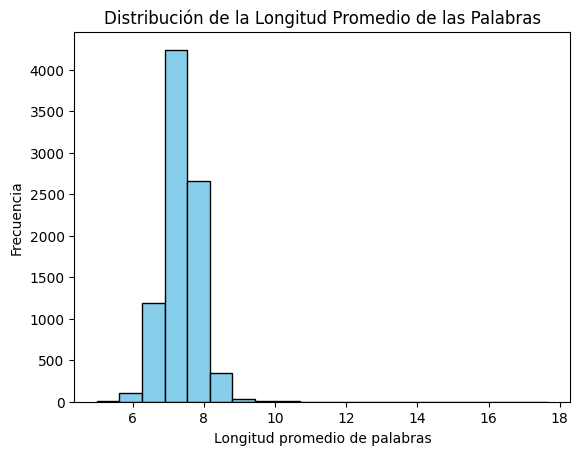

In [13]:
# Importaciones necesarias
#import matplotlib.pyplot as plt

# Calcular la longitud promedio de las palabras por reseña
df['word_length'] = df['cleaned_review_text'].apply(
    lambda x: np.mean([len(word) for word in x.split()])
)

# Estadísticas descriptivas
print("Estadísticas descriptivas de la longitud de las palabras:")
print(df['word_length'].describe())

# Visualización: Histograma de la longitud promedio de las palabras
plt.hist(df['word_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud Promedio de las Palabras')
plt.xlabel('Longitud promedio de palabras')
plt.ylabel('Frecuencia')
plt.show()


La longitud promedio de las palabras es consistente con el idioma español, donde muchas palabras tienen entre 6 y 8 caracteres. Las palabras más largas pueden deberse a nombres propios o palabras técnicas específicas.

Estadísticas descriptivas de las palabras únicas por reseña:
count    8603.000000
mean       76.359526
std        54.012279
min         2.000000
25%        37.000000
50%        61.000000
75%       102.000000
max       400.000000
Name: unique_word_count, dtype: float64


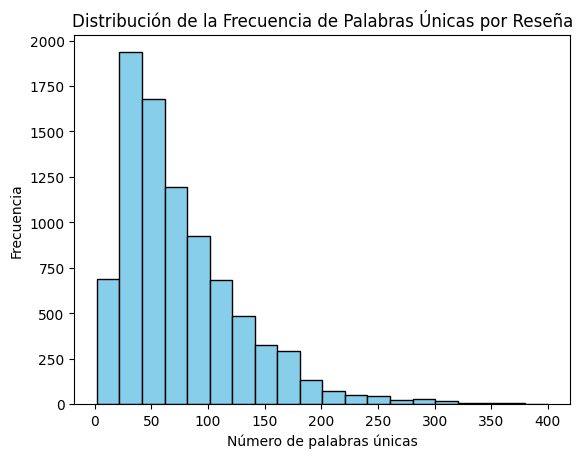

In [14]:
# Calcular la cantidad de palabras únicas por reseña
df['unique_word_count'] = df['cleaned_review_text'].apply(
    lambda x: len(set(x.split()))
)

# Estadísticas descriptivas
print("Estadísticas descriptivas de las palabras únicas por reseña:")
print(df['unique_word_count'].describe())

# Visualización: Histograma de palabras únicas
plt.hist(df['unique_word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas por Reseña')
plt.xlabel('Número de palabras únicas')
plt.ylabel('Frecuencia')
plt.show()


Las reseñas tienen un rango variado de palabras únicas, con una buena cantidad de diversidad en el lenguaje, lo cual será útil para modelado y análisis.

Bigramas más comunes:
cine español: 1687
película española: 470
santiago segura: 468
banda sonora: 432
dani rovira: 430
apellidos vascos: 399
guerra civil: 378
efectos especiales: 355
karra elejalde: 345
belén rueda: 338


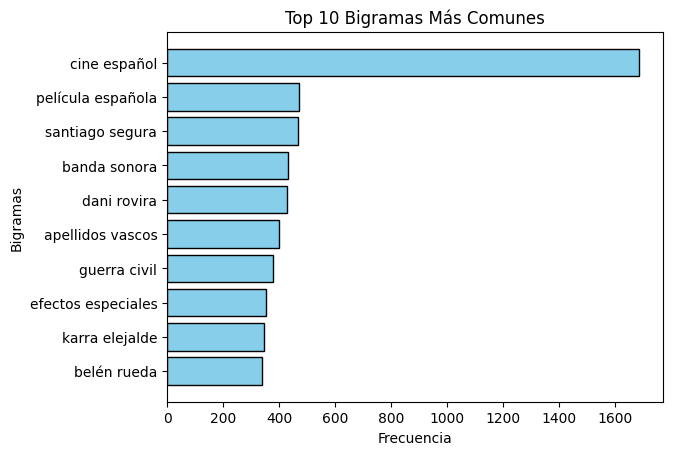

In [15]:
# Importar CountVectorizer y la lista de stopwords de spaCy
# from sklearn.feature_extraction.text import CountVectorizer
# import spacy

# Cargar modelo en español para obtener las stopwords
nlp = spacy.load('es_core_news_sm')
stopwords = list(nlp.Defaults.stop_words)

# Configurar el vectorizador para bigramas (n-gramas de longitud 2)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords)
X = vectorizer.fit_transform(df['cleaned_review_text'].dropna())

# Obtener los bigramas más comunes
bigram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))

# Mostrar los 10 bigramas más comunes
print("Bigramas más comunes:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count}")

# Visualización de los bigramas más comunes
# import matplotlib.pyplot as plt

# Preparar datos para el gráfico
bigrams, counts = zip(*bigram_counts.most_common(10))

# Crear el gráfico
plt.barh(bigrams, counts, color='skyblue', edgecolor='black')
plt.title('Top 10 Bigramas Más Comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Bigramas')
plt.gca().invert_yaxis()
plt.show()



El análisis de bigramas muestra un enfoque temático bien definido en las reseñas, donde los usuarios destacan géneros, actores y características del cine español. Esto refuerza la idea de que el corpus tiene una alta relevancia para estudios relacionados con esta temática.

Trigramas más comunes:
guerra civil española: 98
juan antonio bayona: 95
proyecto bruja blair: 81
historia cine español: 79
aventuras tadeo jones: 76
pilar lópez ayala: 75
mejores películas españolas: 59
basada hechos reales: 58
alberto san juan: 55
rosa maría sardá: 55


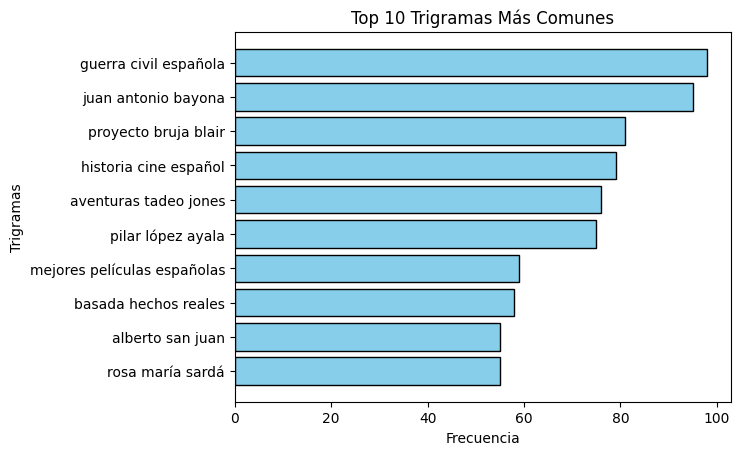

In [16]:
# Configurar el vectorizador para trigramas (n-gramas de longitud 3)
vectorizer_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords)
X_trigrams = vectorizer_trigrams.fit_transform(df['cleaned_review_text'].dropna())

# Obtener los trigramas más comunes
trigram_counts = Counter(dict(zip(vectorizer_trigrams.get_feature_names_out(), X_trigrams.sum(axis=0).A1)))

# Mostrar los 10 trigramas más comunes
print("Trigramas más comunes:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count}")

# Visualización de los trigramas más comunes
# import matplotlib.pyplot as plt

# Preparar datos para el gráfico
trigrams, trigram_counts_values = zip(*trigram_counts.most_common(10))

# Crear el gráfico
plt.barh(trigrams, trigram_counts_values, color='skyblue', edgecolor='black')
plt.title('Top 10 Trigramas Más Comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Trigramas')
plt.gca().invert_yaxis()
plt.show()


El análisis de trigramas confirma un enfoque temático bien definido y una mezcla de conceptos generales (como "historia cine español") y elementos específicos (nombres propios y títulos). Este nivel de detalle puede ser útil para tareas de clasificación temática o análisis semántico.

Cuatrigramas más comunes:
jaume balagueró paco plaza: 34
carmen machi karra elejalde: 33
cobeaga diego san josé: 33
borja cobeaga diego san: 32
naomi watts ewan mcgregor: 32
raúl arévalo javier gutiérrez: 31
torrente brazo tonto ley: 24
dani rovira clara lago: 23
karra elejalde carmen machi: 20
the blair witch project: 19


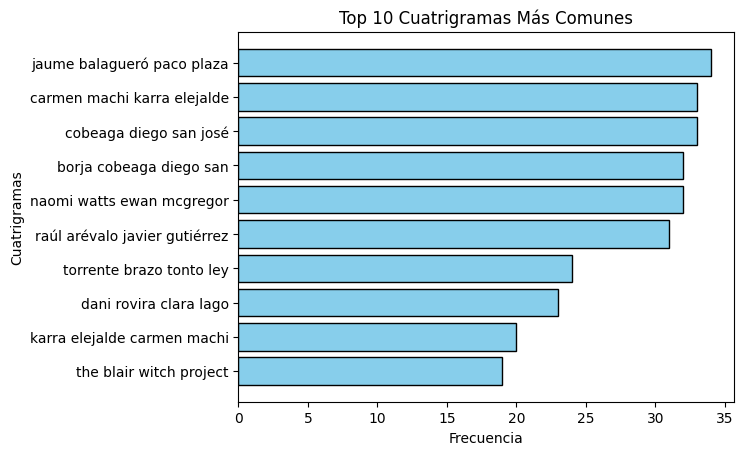

In [17]:
# Configurar el vectorizador para cuatrigramas (n-gramas de longitud 4)
vectorizer_cuatrigramas = CountVectorizer(ngram_range=(4, 4), stop_words=stopwords)
X_cuatrigramas = vectorizer_cuatrigramas.fit_transform(df['cleaned_review_text'].dropna())

# Obtener los cuatrigramas más comunes
cuatrigram_counts = Counter(dict(zip(vectorizer_cuatrigramas.get_feature_names_out(), X_cuatrigramas.sum(axis=0).A1)))

# Mostrar los 10 cuatrigramas más comunes
print("Cuatrigramas más comunes:")
for cuatrigrama, count in cuatrigram_counts.most_common(10):
    print(f"{cuatrigrama}: {count}")

# Visualización de los cuatrigramas más comunes
import matplotlib.pyplot as plt

# Preparar datos para el gráfico
cuatrigramas, cuatrigram_counts_values = zip(*cuatrigram_counts.most_common(10))

# Crear el gráfico
plt.barh(cuatrigramas, cuatrigram_counts_values, color='skyblue', edgecolor='black')
plt.title('Top 10 Cuatrigramas Más Comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Cuatrigramas')
plt.gca().invert_yaxis()
plt.show()


El análisis de cuatrigramas refuerza la temática orientada al cine en el corpus, con una clara tendencia a mencionar equipos creativos y nombres relacionados con el mundo cinematográfico.

Estadísticas descriptivas de la diversidad léxica:
count    8603.000000
mean        0.920725
std         0.055676
min         0.408257
25%         0.885714
50%         0.926554
75%         0.961538
max         1.000000
Name: lexical_diversity, dtype: float64


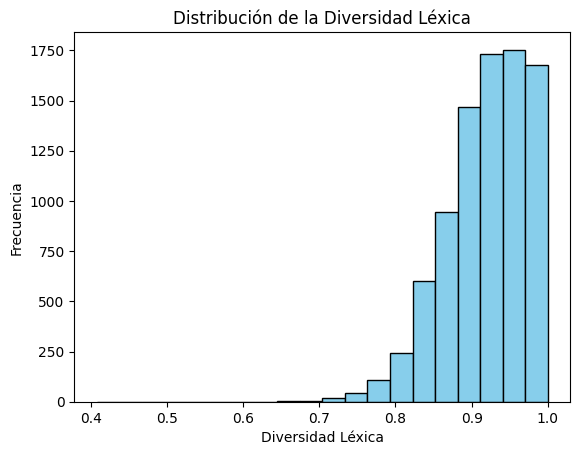

In [18]:
# Calcular la diversidad léxica (razón entre palabras únicas y palabras totales)
df['lexical_diversity'] = df['cleaned_review_text'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)

# Estadísticas descriptivas
print("Estadísticas descriptivas de la diversidad léxica:")
print(df['lexical_diversity'].describe())

# Visualización: Histograma de la diversidad léxica
plt.hist(df['lexical_diversity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Diversidad Léxica')
plt.xlabel('Diversidad Léxica')
plt.ylabel('Frecuencia')
plt.show()


El corpus tiene una alta diversidad léxica en general, lo que refleja que los usuarios tienden a usar vocabulario variado en sus reseñas. Este hallazgo es consistente con la riqueza del idioma español y es útil para tareas de modelado donde la variedad de vocabulario es importante.

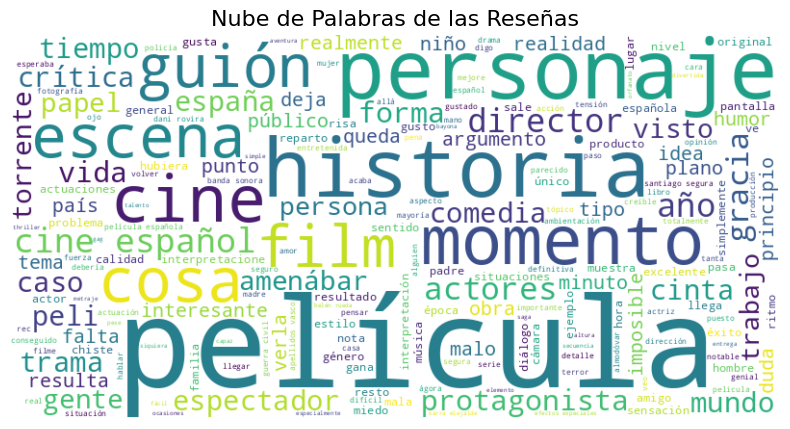

In [19]:
# Importar la librería para Word Cloud
# from wordcloud import WordCloud

# Combinar todas las reseñas en un solo texto
all_reviews = " ".join(df['cleaned_review_text'].dropna())

# Generar la nube de palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=stopwords
).generate(all_reviews)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de las Reseñas', fontsize=16)
plt.show()


Palabras más destacadas:

"película" y "personaje" son las palabras más prominentes, lo que refleja el tema principal del corpus (reseñas de películas).
Otros términos frecuentes como "historia", "momento", "cine", y "escena" muestran el enfoque en aspectos narrativos y cinematográficos.
Temática general:

La nube de palabras resalta términos asociados con crítica y análisis cinematográfico, como "guion", "director", y "actores".
Se observan menciones a géneros como "comedia" y palabras relacionadas con emociones o evaluaciones, como "vida", "gracia", y "crítica".

##Conclusión del Análisis Exploratorio
**Resumen general:**

El corpus tiene una alta diversidad léxica y está dominado por términos relacionados con el cine, tanto en aspectos técnicos como narrativos.
Los bigramas, trigramas, y cuatrigramas muestran un enfoque temático consistente, destacando nombres propios, títulos de películas y conceptos relacionados con el cine español.

**Implicaciones:**

La riqueza léxica y la estructura temática del corpus lo hacen adecuado para tareas de análisis de sentimientos, modelado de temas o clasificación.